# C LOARKS matrix 
###### Author: Zimu Huo
###### Date: 07.2022

<div style="font-size: 1.2em;">
The theory of structured low rank interpolation and its relationship with an annihilating filter has been extensively studied. If the image $x$ has finite support within the FOV, then there exists a smooth spatial domain annihilating function $\hat h$, which is non-zero outside the support of the image $x$ and zero within the finite support region. Consequently, when this filter is applied to the image, the product is zero, hence,

\begin{equation} 
x \cdot \hat h = 0. 
\end{equation}

Using the duality of Fourier transform, the spatial domain multiplication translates into convolution with $h$ in Fourier domain, 

\begin{equation}
(F \cdot x) *  h = 0. 
\end{equation}

The $*$ symbol denotes convolution. Since $\hat h$ is spatially smooth by construction, the filter $h$ is band-limited. Equations of this form, where one side is set to zero, are referred to as annihilation relations. The data $x$ can be predicted using a local linear model from the shift invariant coefficients of the filter $h$ (i.e., predict the value of the target coefficient using the weighted sum of other samples in the local neighborhood of k-space). For instance, consider a local k-space region consisting of three samples, denoted as $ k_1 $, $ k_2 $, and $ k_3 $, with corresponding filter coefficients $ w_1 $, $ w_2 $, and $ w_3 $, such that $\sum_{i=1}^{3} w_i k_i = 0$ (i.e., annihilation). Given all the filter coefficients and knowing the values of samples $ k_1 $ and $ k_2 $, we can explicitly determine the missing sample $ k_3 $ as follows: $k_3 = -\frac{w_1 k_1 + w_2 k_2}{w_3} $. Structured low-rank algorithms aim to implicitly determine the local relationships in k-space by using a low-rank Hankel matrix of the data as a prior (without explicitly computing the filter coefficients). To do this, the convolution in equation 5 can be rewrite as matrix multiplication, which requires each small k-space patch at each k-space location to be flattened into a row vector and concatenating all the row vectors to form a 2D Hankel matrix. This process is referred to as the Hankel transformation, which we will denote by the symbol $H$, 

\begin{equation}
(H F x) \times  h = 0.
\end{equation}

The Hankel matrix exhibits a null-space vector associated with the filter coefficients $h$. Given that it is possible to derive a large set of linearly independent equations, the Hankel matrix consequently possesses a non-trivial null-space and is low rank.

The low rank based method will recover the missing data by enforcing self-consistency among neighboring k-space points in Cartesian space when minimizing the rank of the structured Hankel matrix. The self-consistency refers to the annihilation relationship being satisfied for all locations in k-space. Directly solving rank problems is computationally challenging and falls under the category of NP-hard problems. To address this, the non-convex rank function is replaced with its convex relaxation, which is replacing the non-convex rank function with its convex approximation, known as the nuclear norm. Thus, the problem of the missing data in the center of k-space is reformulated as a structured locally low rank nuclear norm minimization problem, as expressed by the following:

\begin{equation}
\begin{aligned}
\min_{x} \quad &  \quad & ||DFSx - y||^2  + \lambda ||HFSx||_*
\end{aligned}
\end{equation}

Here, H represents the matrix lifting operator, which converts 3D Cartesian data into a structured Hankel matrix and * denotes the nuclear norm. The P-LORAKS framework necessitates that data be structured on a Cartesian grid. Therefore, we start by converting the non-Cartesian radial data into a 3D Cartesian grid. Subsequently, the Cartesian data are organized into GRAPPA-like kernels. Each kernel is then flattened, creating columns within a 2D Hankel matrix, as described in prior studies. This process is iterated by convolving the kernel across either the entire k-space or a predefined center region. In instances where a fully sampled ZTE acquisition is in use, only the center data is absent, thus only the center volume is needed. To enforce self-consistency and low rankness, we apply the Singular Value Thresholding (SVT) to the Hankel matrix, employing either hard or soft thresholding on the singular values. Subsequently, the Cartesian data is inverse-transformed into non-Cartesian space to maintain data consistency by replacing the data with the acquired data. This can be solved efficiently using Projection-onto-Convex-Sets (POCS) algorithm. 
</div>


-------------------------------------------------------------------------
References
    
    [1] 
    Author: Justin P. Haldar 
    Title: Low-Rank Modeling of Local-Space Neighborhoods (LORAKS) for Constrained MRI
    Link: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6678771

In [7]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
from util.phantom import * 
from util.rank import *
from tqdm.notebook import tqdm
from util.grappa import *

In [8]:
def get_tissue_images():
    tissuetype = ['graymatter', 'deep_graymatter', 'whitematter', 'csf']
    T2 = [110, 100, 60, 1500]
    T2s = [40, 45, 50, 1000]
    mat = scipy.io.loadmat('../lib/tissue_images.mat')
    tissues = mat.get("tissue_images")
    return np.squeeze(tissues), tissuetype, T2
def gaussian_noise(shape,  mu = 0, sigma = 1):
    n = np.zeros(shape, dtype = complex)
    n.real = np.random.normal(mu, sigma, np.prod(shape)).reshape(shape)
    n.imag = np.random.normal(mu, sigma, np.prod(shape)).reshape(shape)
    return n.reshape(shape)
from util.zpad import * 
tissues,tissuetype, t2 = get_tissue_images()
ny, nx, nz, nt = tissues.shape
TE = 100
ideal_image = np.zeros([ny, nx, nz], dtype = complex)
for t in range(nt):
    ideal_image += tissues[...,t] * np.exp(TE/t2[t])
images = ideal_image
N = ny = nx = 256
images = zpad(images, [ny, ny, ny], (0, 1, 2))
nc = 4
images = images[:,:,120]
images = np.repeat(images[:, :, np.newaxis], nc, axis=2)
images = images * generate_birdcage_sensitivities(matrix_size = N,number_of_coils = nc)
images = np.squeeze(images)
data = fft2c(images)

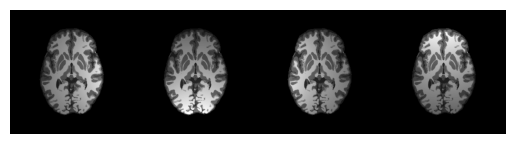

In [9]:
show(images,1)

In [12]:
# define matrix lifting and unlifting operators for C matrix 
def PLOARKS_C(data, kx, ky):
    [ny, nx, nc] = data.shape
    data = np.moveaxis(data, -1, 0)
    mat = np.zeros([(ny-ky+1)*(nx-kx+1), kx * ky * nc], dtype = complex)
    idx = 0
    for y in range(max(1, ny - ky + 1)):
        for x in range(max(1, nx - kx + 1)):
            mat[idx, :] = data[:,y:y+ky, x:x+kx].reshape(1,-1)
            idx += 1
    return mat

def PLOARKS_Cinv(data, kx, ky, shape):
    [ny, nx, nc] = shape
    [nt, ks] = data.shape
    data = data.reshape(nt, nc, ky , kx)
    mat = np.zeros([nc, ny, nx], dtype = complex)
    count = np.zeros([nc, ny, nx])
    idx = 0
    for y in range(max(1, ny - ky + 1)):
        for x in range(max(1, nx - kx + 1)):
            mat[:,y:y+ky, x:x+kx] += data[idx]
            count[:,y:y+ky, x:x+kx] += 1 
            idx += 1
    mat = mat/count
    return np.moveaxis(mat, 0, -1) 

In [13]:
# define matrix lifting and unlifting operators with coil augmentation 
def PLOARKS_VCC(data, kx, ky):
    data = np.concatenate((data, np.conj(data)), axis=-1)
    [ny, nx, nc] = data.shape
    data = np.moveaxis(data, -1, 0)
    mat = np.zeros([(ny-ky+1)*(nx-kx+1), kx * ky * nc], dtype = complex)
    idx = 0
    for y in range(max(1, ny - ky + 1)):
        for x in range(max(1, nx - kx + 1)):
            mat[idx, :] = data[:,y:y+ky, x:x+kx].reshape(1,-1)
            idx += 1
    return mat

def PLOARKS_VCCinv(data, kx, ky, shape):
    [ny, nx, nc] = shape
    [nt, ks] = data.shape
    data = data.reshape(nt, nc * 2, ky , kx)
    mat = np.zeros([nc*2, ny, nx], dtype = complex)
    count = np.zeros([nc*2, ny, nx])
    idx = 0
    for y in range(max(1, ny - ky + 1)):
        for x in range(max(1, nx - kx + 1)):
            mat[:,y:y+ky, x:x+kx] += data[idx]
            count[:,y:y+ky, x:x+kx] += 1 
            idx += 1
    mat = mat/count
    mat = (mat[:nc,...] + np.conj(mat[nc:,...]))/2
    return np.moveaxis(mat, 0, -1) 


In [20]:
# generate undersampling mask
mask =var_dens_mask(data.shape, 0.0001)
undersampling_rate(mask)

0.5360527038574219

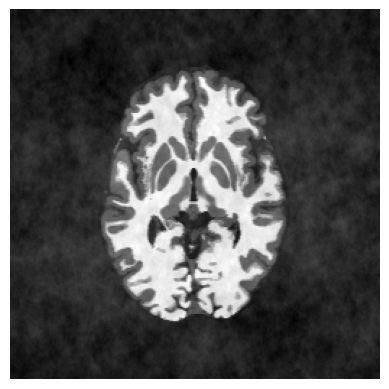

In [21]:
dataR = data * mask 
show(rsos(ifft2c(dataR)))

In [22]:
thres = 0.01
out = np.copy(dataR)
kx = ky = 5
rank = 75
for i in tqdm(range(20)):
    C = PLOARKS_C(out, kx, ky)
    # inspect_rank(C, thres)
    Cr = rank_approx(C, rank)
    out = PLOARKS_Cinv(Cr, kx, ky, out.shape)
    out = out * np.abs(1-mask) + dataR
    # plt.figure()
    # plt.subplot(121)
    # plt.imshow(np.abs(rsos(ifft2c(out))), cmap ="gray")
    # plt.subplot(122)
    # plt.imshow(np.abs(rsos(ifft2c(out)))-np.abs(rsos(ifft2c(data))), cmap ="jet")
    # plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
def l2(a, b):
    return np.linalg.norm(np.abs(a.flatten()) - np.abs(np.abs(b.flatten())))

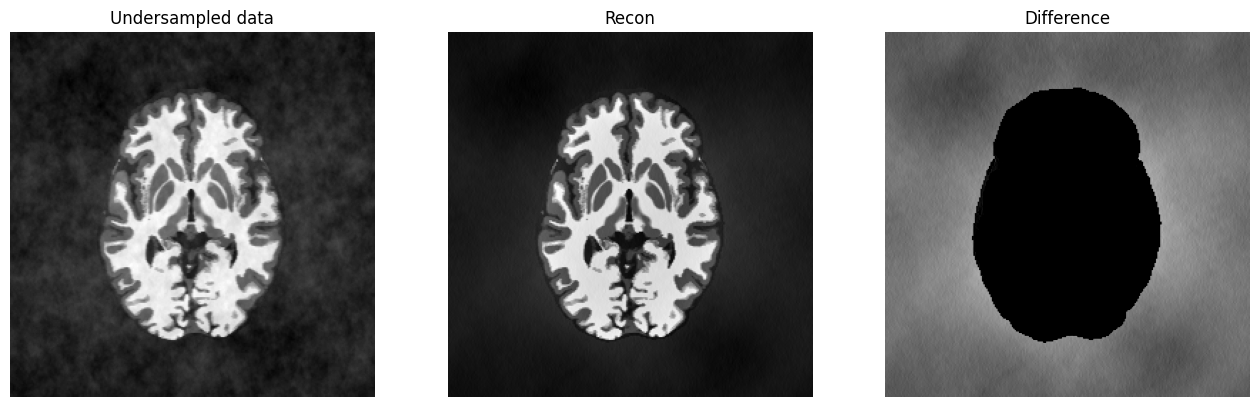

223.70133230802017


In [36]:
plt.figure(figsize= (16,12))
plt.subplot(131)
plt.imshow(np.abs(rsos(ifft2c(dataR))), cmap ="gray")
plt.axis("off")
plt.title("Undersampled data")
plt.subplot(132)
plt.imshow(np.abs(rsos(ifft2c(out))), cmap ="gray")
plt.axis("off")
plt.title("Recon")
plt.subplot(133)
plt.imshow(np.abs(rsos(ifft2c(out)))-np.abs(rsos(ifft2c(data))), cmap ="gray", vmin = 0, vmax = 2)
plt.title("Difference")
plt.axis("off")
plt.show()
print(l2(np.abs(rsos(ifft2c(out))), np.abs(rsos(ifft2c(data)))))